# R-CNN training on the Kaggle dataset

### Imports

In [288]:
import torchvision.datasets
import os
import random as rd
import torchvision.transforms
import torch.nn.functional as F
import torch
from torchsummary import summary
import torch.nn as nn
import tqdm
from PIL import Image
import cv2
from PIL import ImageDraw
import matplotlib.pyplot as plt

In [2]:
from python_files.get_data import *
from python_files.resnetclass import *

## Data loading

In [3]:
def dataset(path):
    return torchvision.datasets.ImageFolder(
        root=path)

In [4]:
path_buff = '/home/efficientnet/notebooks/af_data/africa_dataset/only_buff'
path_zebra = '/home/efficientnet/notebooks/af_data/africa_dataset/only_zebra'
path_rhino = '/home/efficientnet/notebooks/af_data/africa_dataset/only_rhino'
path_elephant = '/home/efficientnet/notebooks/af_data/africa_dataset/only_elephant'

In [5]:
path_buff_2 = path_buff + '/buffalo/'
path_zebra_2 = path_zebra + '/zebra/'
path_rhino_2 = path_rhino + '/rhino/'
path_elephant_2 = path_elephant + '/elephant/'

In [6]:
#liste_fichiers = os.listdir(path_zebra_2)
#liste_fichiers = os.listdir(path_elephant_2)
#liste_fichiers = os.listdir(path_rhino_2)
liste_fichiers = os.listdir(path_buff_2)
n = 377 ##001 à 377
list_names = []
for i in range(1,10):
    list_names.append('00'+str(i))
for i in range(10, 100):
    list_names.append('0'+str(i))
for i in range(100, 378):
    list_names.append(str(i))
for name in list_names:
    if not((name+'.jpg' in liste_fichiers and name+'.txt' in liste_fichiers)):
        print("probleme", name, (name+'.jpg' in liste_fichiers), (name+'.txt' in liste_fichiers))

probleme 182 False True
probleme 286 False False


In [7]:
def get_detection_dataset(path):
    liste_fichiers = os.listdir(path)
    n_max = max([int(nom[:3]) for nom in liste_fichiers])
    res = []
    for i in range(1, 1+n_max):
        if i<10:
            name_base = '00'+str(i)
        elif i<100:
            name_base = '0'+str(i)
        else:
            name_base = str(i)
            
        if not((name_base+'.jpg' in liste_fichiers and name_base+'.txt' in liste_fichiers)):
            continue 
        else:
            name_im_file = name_base+'.jpg'
            name_txt_file = name_base+'.txt'
            im = Image.open(path + name_im_file)
            rects = []
            with open(path+name_txt_file, "r") as file:
                for line in file.readlines():
                    l = line.split(' ')
                    coords = float(l[1]), float(l[2]), float(l[3]), float(l[4].strip())
                    label = int(l[0])
                    rects.append((label, coords))
        res.append((im, rects))
    return res

In [8]:
det_dataset =get_detection_dataset(path_buff_2) +get_detection_dataset(path_zebra_2)+get_detection_dataset(path_rhino_2)+get_detection_dataset(path_elephant_2)

## Data preparation

In [9]:
def interpolate(img, res):
    if img.ndim ==4:
        img_perm = F.interpolate(img, size = res)
        img_perm = img_perm.permute(0,1,3,2)
        img_perm = F.interpolate(img_perm, size =res)
        img_perm = img_perm.permute(0,1,3,2)
        return img_perm
    elif img.ndim==3:
        img_perm = F.interpolate(img, size = res)
        img_perm = img_perm.permute(0,2,1)
        img_perm = F.interpolate(img_perm, size =res)
        img_perm = img_perm.permute(0,2,1)
        return img_perm
    else:
        raise Exception("tensor dimension should be 3 or 4")
    

In [10]:
det_dataset = rd.sample(det_dataset, len(det_dataset))

In [11]:
t = torchvision.transforms.ToTensor()
det_data_t = [(interpolate(t(image),140), label) for (image, label) in det_dataset]

## Backbone network recuperation

In [12]:
resnet = get_resnet(width = 17, resolution=140,depth=[3,3,2,2], num_classes = 4)

In [13]:
path = '/home/efficientnet/notebooks/notebooks/models/resnetaf5.txt'

In [16]:
resnet.load_state_dict(torch.load(path))

<All keys matched successfully>

##  Selective Search & IoU  (from the TDs)

In [ ]:
def selectivesearch(img):
  """
  SelectiveSearch : 
  - image au format openCV  
  - renvoie une liste de quadruplets (x,y,w,h) représentant les zones de 
    prédiction
  """
  ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
  ss.setBaseImage(img)
  # Deux modes de détections sont possibles : Fast et Quality
  ss.switchToSelectiveSearchFast()
  #ss.switchToSelectiveSearchQuality()
  return ss.process()


In [245]:
def IoU(rect1,rect2):
  """ 
  Renvoie un float avec le IoU entre rect1 et rect2 :
  rect1, rect2 : quadruplets (x,y,w,h) 
  """
  x1,y1,w1,h1 = rect1
  x2,y2,w2,h2 = rect2
  xA,yA = max(x1,x2),max(y1,y2)
  xB,yB = min(x1+w1,x2+w2),min(y1+h1,y2+h2)
  inter = max(0,xB - xA)*max(0,yB-yA)
  union = w1*h1 + w2*h2 - inter
  return inter/union

## Some preliminary functions for R-CNN

In [382]:
def iou_yolo(rect1, rect2, glob_im):
    _,W,H = glob_im.size()
    x1, y1, w1, h1 = rect1 
    x2, y2, w2, h2 = rect2
    xa = x1 - w1/2
    xb = x2 - w2/2
    ya = y1 - h1/2
    yb = y2 - h2/2
    ha, hb = h1*H, h2*H
    wa, wb = w1*W, w2*W
    ra = [xa, ya, wa, ha]
    rb = [xb, yb, wb, hb]
    return IoU(ra,rb)

In [383]:
def is_positive(region, list_rec_lab, glob_im):
    res = False
    for _, rec in list_rec_lab:
        i = iou_yolo(region, rec, glob_im)
        if i>.5:
            res=True
            region_pos = rec
            return res, rec
    return False

In [384]:
def crop_tensor(image,region):
    x,y,w_r,h_r = region
    _,w,h = image.size()
    x_abs ,y_abs = w*x ,h*y
    y_top = y_abs - h_r*h/2
    x_left = x_abs - w_r*w/2
    return image[:, int(y_top):int(y_top+h_r*h),int(x_left):int(x_left+w_r*w)]

In [385]:
def remove_out_rects(rects,image_t,mn =0.1 , mx = 0.9):
    res = []
    for r in rects:
        _,_,w,h = r
        _, wb, hb = image_t.size()
        if w/wb > mn and w/wb < mx and h/hb > mn and h/hb < mx:
            res.append(r)
    return res

In [386]:
def get_regions(img_t):
    img_pil = img_t.permute(1,2,0).numpy()
    _,W,H = img_t.size()
    rects = selectivesearch(img_pil)
    rects = remove_out_rects(rects, img_t)
    res = []
    for rect in rects:
        x,y,w,h = rect
        x_c = (x + w/2)/W
        y_c = (y + h/2)/H
        w_r = w/W
        h_r = h/H
        res.append((x_c, y_c, w_r, h_r))
    return res

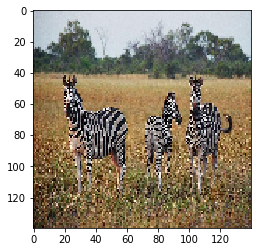

In [387]:
# test crop
image, grl = det_data_t[77]
plt.imshow(image.permute(1,2,0))
plt.show()
region=grl[1][1] 
im_propo = crop_tensor(image, region)
plt.imshow(im_propo.permute(1,2,0))
plt.show()

In [390]:
dict_labels = {0:'buffalo', 1 : "elephant", 2: "rhino", 3 : "zebra", 4:"background"}

## Functions for testing the classifier

In [391]:
def get_clf_dataset(det_dataset):
    res = []
    # tuple image (croppée), label
    for im, list_lab_rec in det_dataset:
        for label, rectangle in list_lab_rec:
            crop_im = crop_tensor(im, rectangle)
            res.append((crop_im, label))
    return res

#im =det_dataset[10][0]

clf_dataset = get_clf_dataset(det_data_t)

dict_labels = {0:'buffalo', 1 : "elephant", 2: "rhino", 3 : "zebra", 4:"background"}

In [392]:
def show_clfpred(dataset,model):
    n = len(dataset)
    m = r.randint(0,n)
    im, lbl = dataset[m]
    im2 = interpolate(im, 140)
    im2 = im2.resize(1, 3, 140, 140).to('cuda')
    clf, bbox = model(im2)
    _, predicted = torch.max(clf.data, 1)
    predicted = int(predicted)
    print('true label : ', dict_labels[lbl], ' - predicted : ', dict_labels[predicted])
    plt.imshow(im.permute(1,2,0))
    plt.show()

true label :  zebra  - predicted :  background


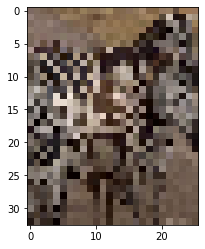

In [84]:
show_clfpred(clf_dataset,rcnn_model)

## Functions for testing the backbone network

In [393]:
def get_accuracyresnet(model, testset):
    ok, tot = 0,0
    for im, lbl in testset :
        im2 = interpolate(im, 140)
        im2 = im2.resize(1, 3, 140, 140).to('cuda')
        clf = model(im2)
        _, predicted = torch.max(clf.data, 1)
        predicted = int(predicted)
        if predicted==lbl:
            ok+=1
            tot+=1
        else:
            tot+=1
    return ok/tot

In [218]:
resnet2 = resnet.to('cuda')

In [220]:
get_accuracyresnet(resnet2, clf_dataset[:150])

0.8533333333333334

# R-CNN architecture

In [395]:
class SVM(nn.Module):
    def __init__(self,out_size=1088,num_classes=4):
        super(SVM, self).__init__()
        self.classifier = nn.Linear(out_size, num_classes+1)
        
    def forward(self, x):
        return self.classifier(x)

In [81]:
testsvm = SVM()

In [143]:
resnet = resnet.to('cuda')

In [396]:
def fwd_pass(svm, resnet, image):
    out = resnet.pool(resnet.layers(resnet.bn1(resnet.conv1(image))))
    out = out.view(out.size(0), -1)
    return svm(out)

In [397]:
def get_accuracy_clf(model, testset):
    ok, tot = 0,0
    for im, lbl in testset :
        im2 = interpolate(im, 140)
        im2 = im2.resize(1, 3, 140, 140).to('cuda')
        clf = fwd_pass(model, resnet, im2)
        _, predicted = torch.max(clf.data, 1)
        predicted = int(predicted)
        if predicted==lbl:
            ok+=1
            tot+=1
        else:
            tot+=1
    return ok/tot

In [398]:
class BboxRegressor(nn.Module):
    def __init__(self,out_size=1088,num_classes=4):
        super(BboxRegressor, self).__init__()
        self.classifier = nn.Linear(out_size, 4)
        
    def forward(self, x):
        return F.sigmoid(self.classifier(x))

In [399]:
def prop_bck(classifier, clf_set, m):
    tot = 0
    four =0
    for im, lbl in clf_set[:m]:
        im  = interpolate(im, 140).resize(1, 3, 140, 140).to('cuda')
        out = fwd_pass(classifier, resnet, im)
        _, pred = torch.max(out, axis = 1)
        pred = int(pred)
        tot+=1
        if pred ==4:
            four +=1
    return(four/tot)

In [400]:
def sample_regions(ds_detect_t, pos = 32,neg = 96):
    n_pos, n_neg =0, 0
    N = len(ds_detect_t)
    res = []
    while n_pos<pos or n_neg<neg:
        im, list_rect_labels = rd.sample(ds_detect_t, 1)[0]
        region_prop = get_regions(im)
        for region in region_prop:
            isp = is_positive(region, list_rect_labels, im)
            if isp==False and n_neg<neg:
                res.append((region, list_rect_labels[0][0], im))
                n_neg+=1
            elif type(isp)==tuple and n_pos<pos:
                _, rec = isp
                res.append((region, list_rect_labels[0][0], rec, im))
                n_pos+=1
    return res
    
    

In [642]:
def train_rcnn(classifier,regressor,opt_c, opt_r, ds_detect_t,clf_set, n_epoch = 200, k=100, per=40):
    loss_clf,loss_reg = torch.nn.CrossEntropyLoss(),torch.nn.SmoothL1Loss()
    for i in tqdm.notebook.tqdm(range(n_epoch)):
        regions = sample_regions(ds_detect_t, pos = 100, neg = 28)
        run_loss=0
        tot_bck,good_bck =0,0
        for reg in regions:
            opt_c.zero_grad()
            opt_r.zero_grad()
            
            if len(reg)==3:
                # region negative
                region, label, image = reg
                ipt_net = crop_tensor(image, region)
                ipt_net = interpolate(ipt_net, 140).resize(1, 3, 140, 140).to('cuda')
                clf = fwd_pass(classifier, resnet,ipt_net)
                # background recall 
                _,pred_lbl = torch.max(clf,axis=1)
                pred_lbl= int(pred_lbl)
                tot_bck+=1
                if pred_lbl==4:
                    good_bck+=1
                # loss + backward    
                loss_c =loss_clf(clf, torch.tensor([4]).to('cuda'))
                run_loss += loss_c 
                loss_c.backward()
                opt_c.step()
            else:
                # region positive
                region, label, gt_rect, image = reg
                ipt_net = crop_tensor(image, region)
                ipt_net = interpolate(ipt_net, 140).resize(1, 3, 140, 140).to('cuda')
                clf = fwd_pass(classifier, resnet,ipt_net)
                loss_c = loss_clf(clf, torch.tensor([label]).to('cuda'))
                run_loss +=loss_c
                bbox = fwd_pass(regressor, resnet, ipt_net)
                loss_r = loss_reg(bbox, torch.tensor(gt_rect).to('cuda'))
                run_loss+=loss_r
                loss_c.backward()
                loss_r.backward()
                opt_c.step()
                opt_r.step()
        ## disp stats
        if i%per==0:
            acc_clf =  get_accuracy_clf(classifier, clf_set[:k])
            prp_bck = prop_bck(classifier, clf_set, 150)
            bck_rec =good_bck/tot_bck
            if acc_clf >0.7:
                print('accuracy clf : ', acc_clf, 'loss : ' ,float(run_loss))
                print('proportion background (doit etre 0)', prp_bck)
                print('background recall (doit etre 1) : ', good_bck/tot_bck)
            if acc_clf > 0.75 and prp_bck <.10 and bck_rec > .65:
                path = '/home/efficientnet/notebooks/notebooks/models/classif.txt'
                torch.save(classifier.state_dict(),path)
                path = '/home/efficientnet/notebooks/notebooks/models/reg.txt'
                torch.save(regressor.state_dict(),path)
                print('new cand : ' , 'classif' , acc_clf, 'prop back',  prp_bck, 'recall back', bck_rec, 
                     'loss', float(run_loss))
    return classifier, regressor

In [ ]:
testsvm = SVM()
testsvm = testsvm.to("cuda")
opt_c = torch.optim.Adam(testsvm.parameters(), lr = 1e-2)

bbr = BboxRegressor()
bbr = bbr.to("cuda")
opt_r = torch.optim.SGD(bbr.parameters(), lr = 1e-2, weight_decay = .9)



classifier, regressor, cands= train_rcnn(testsvm,bbr,opt_c, opt_r, det_data_t,clf_dataset, 
                                        n_epoch = 1500, k=400, per = 10)

In [436]:
classif = SVM()
classif = classif.to("cuda")
bbr = BboxRegressor()
bbr = bbr.to("cuda")

path1='/home/efficientnet/notebooks/notebooks/models/classif.txt'
path2='/home/efficientnet/notebooks/notebooks/models/reg.txt'

classif.load_state_dict(torch.load(path1))
bbr.load_state_dict(torch.load(path2))

<All keys matched successfully>

In [574]:
def get_predictions_clf(classifier, bbr, image, iou=.1):
    classifier = classifier.eval()
    region_prop = get_regions(image)
    res = []
    for reg in region_prop:
        ipt_net = crop_tensor(image, reg)
        ipt_net = interpolate(ipt_net, 140)
        ipt_net = ipt_net.resize(1, 3, 140, 140)
        ipt_net = ipt_net.to('cuda')
        clf= fwd_pass(classifier, resnet,ipt_net)
        bbox= fwd_pass(bbr, resnet, ipt_net)
        #print(bbox)
        probas = F.softmax(clf)
        label = torch.argmax(probas)
        max_prob = torch.max(probas)
        if label!= 4:
            rectangle = bbox[0][0], bbox[0][1], bbox[0][2], bbox[0][3]
            ajouter = True 
            for tpt in res:
                lbl,prb,rect = tpt
                if int(lbl)==int(label) and iou_yolo(rect, rectangle, image) > iou:
                      # on a deja détecté ce rectagle
                    ajouter = False
            if ajouter :
                res.append((label.data,max_prob.data, rectangle))        
    return res


def plot_corrections_clf(classifier,bbr, dataset,n):
    image = dataset[n][0]
    vrai_rect =  dataset[n][1][0][1]
    preds=get_predictions_clf(classifier,bbr, image)
    t = torchvision.transforms.ToPILImage()
    _, W, H = image.size()
    imagepil = t(image)
    predictions = []
    for label, max_prob, box in preds : 
        x,y,w,h = box
        rect =(x-w/2)*W, (y-h/2)*H, w*W, h*H
        if max_prob>0.6:
            predictions.append((rect,label, max_prob))
    imOut = imagepil
    img1 = ImageDraw.Draw(imOut)  
    xv,yv,wv,hv = vrai_rect
    xp,yp,wp,hp = (xv-wv/2)*W, (yv-hv/2)*H, wv*W, hv*H
    for rect,label,score in predictions:
        x, y, w, h = rect
        x,y,w,h = int(x), int(y), int(w), int(h) 
        shape = [(x,y), (x+w, y+h)]
        img1.rectangle(shape, outline ="red")
        img1.text((x,y), dict_labels[int(label)], fill=(0,255,255,255))
    shapev = [(xp,yp), (xp+wp,yp+wp )]
    img1.rectangle(shapev, outline = 'green')
    img1.text((xp,yp+wp ), "true box", fill=(0,0,255,255) )        
    plt.imshow(imOut)

/anaconda/envs/py37_pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]


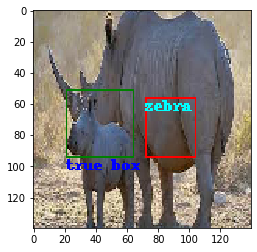

In [575]:
plot_corrections_clf(classif,bbr,det_data_t, 242)

In [610]:
def show_random_result(det_data_t,classif,bbr):
    N = len(det_data_t)
    n = rd.randint(0,N)
    im, _ = det_data_t[n]
    plt.imshow(im.permute(1,2,0))
    plt.show()
    plot_corrections_clf(classif,bbr,det_data_t, n)
    

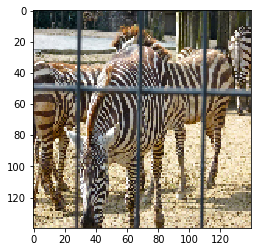

/anaconda/envs/py37_pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]


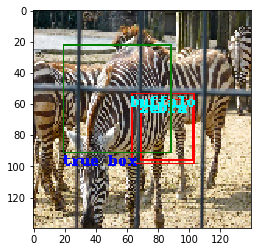

In [621]:
show_random_result(det_data_t, classif, bbr)

In [613]:
def get_clf_recalls(classifier, clf_dataset):
    tots = 4*[0]
    tps = 4*[0]
    # recall pour chaque classe 
    for img, lbl in clf_dataset:
        ipt_net = interpolate(img, 140).resize(1, 3, 140, 140).to('cuda')
        clf = fwd_pass(classifier, resnet,ipt_net)
        _,pred_lbl = torch.max(clf,axis=1)
        pred_lbl= int(pred_lbl)
        tots[lbl]+=1
        if lbl==pred_lbl:
            tps[lbl]+=1
    return [tps[i]/tots[i] for i in range(4)]
        
        
    

In [523]:
get_clf_recalls(classif, clf_dataset[:250])

[0.9423076923076923, 0.03125, 0.5319148936170213, 1.0]

In [524]:
dict_labels

{0: 'buffalo', 1: 'elephant', 2: 'rhino', 3: 'zebra', 4: 'background'}

In [608]:
def get_clf_precision(classifier, clf_dataset):
    tot_preds = 5*[0]
    true_preds = 5*[0]
    # recall pour chaque classe 
    for img, lbl in clf_dataset:
        ipt_net = interpolate(img, 140).resize(1, 3, 140, 140).to('cuda')
        clf = fwd_pass(classifier, resnet,ipt_net)
        _,pred_lbl = torch.max(clf,axis=1)
        pred_lbl= int(pred_lbl)
        tot_preds[pred_lbl]+=1
        if lbl==pred_lbl:
            true_preds[pred_lbl]+=1
    return [true_preds[i]/tot_preds[i] for i in range(5)]
        

In [609]:
get_clf_precision(classif, clf_dataset[:250])

[0.620253164556962, 0.6666666666666666, 0.78125, 0.8787878787878788, 0.0]